# SYSNet: Systematics Treatment with Neural Networks

`SYSNet` was developed to tackle the problem of imaging systematic effects, e.g., Galactic dust, in galaxy survey data.

## 1. Installation

### 1.1 Anaconda Python

We recommend Conda for installing the required packages. First, you need to make sure you have Conda installed or updated in your system. Use the commandd `$> which conda` to see if conda is installed in the system. If not, please follow the instructions given at https://docs.conda.io/projects/conda/en/latest/index.html (or https://docs.conda.io/en/latest/miniconda.html#linux-installers for linux). For instance, I would execute the following commands on Linux:  
```bash
    wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh 
    sha256sum Miniconda3-latest-Linux-x86_64.sh
```

### 1.2 Pytorch

Next, we create an environment (e.g., called `sysnet`) and install Pytorch. We recommend to take a look at the [Pytorch website](https://render.githubusercontent.com/view/pytorch.org) to learn more about the framework. The installation of Pytorch on GPU-available machines is different from CPU-only. For instance, to set up on the Ohio State Cluster (OSC), you should execute the next two commands to load the CUDA library: 
```bash
    module spider cuda # on OSC
    module load cuda/10.1.168 # on OSC
```
*Note* that for other supercomputers, e.g., NERSC, you may have to read the appropriate NERSC documentation to see how you can load the CUDA library. For all other devices, i.e., CPU only, you can skip these steps. Then,
```bash
    conda create -q -n sysnet python=3.8 scikit-learn git jupyter ipykernel ipython mpi4py matplotlib
    conda activate sysnet
    conda install pytorch torchvision -c pytorch  # see below for a GPU-enabled installation
    conda install -c conda-forge fitsio healpy absl-py pytables pyyaml
```
For a GPU-enabled installation (e.g., on OSC), we should execute this command instead (see https://www.osc.edu/resources/available_software/software_list/cuda & https://www.osc.edu/supercomputing/batch-processing-at-osc/monitoring-and-managing-your-job):  
```bash
    conda install pytorch torchvision cudatoolkit=10.1 -c pytorch # on OSC
```

### 1.3 Download and Path (PYTHONPATH) Setup
Finally, we clone (or download) the sysnetdev repository from Github using `git clone https://github.com/mehdirezaie/sysnetdev.git` and add the sysnetdev directory path to the PYTHONPATH variable:

`export PYTHONPATH=\path\to\sysnetdev:$PYTHONPATH`, you need to replace `\path\to\sysnetdev` with the path to sysnetdev in your system. Then, execute the following command in the terminal to add the sysnet kernel to your Jupyter notebook:
```bash
  python -m ipykernel install --user --name=sysnet --display-name "python (sysnet)"
```
In order to test if the installation went correctly. Navigate to the _scripts_ directory, and run the script _app.py_ with `python app.py`. If everything goes smoothly, it means you have installed the package successfully.

## 2. Summary
In general, the process can be separated into three steps: _preprocessing_ (e.g., tabulated data preparation), _regression_, and _post processing_ (e.g., weight assignment). In this notebook, we only focus on the regression process.
#### 2.1 Preprocessing
The input data to `SYSNet` is a tabulated data of the following fields:
1. `hpix`: (int) HEALPix index
2. `label`: (float) number count of galaxies (or quasars) in pixel
3. `fracgood`: (float) weight associated to pixel (the network output will be multiplied by this factor)
4. `features`: (float) array holding imaging properties for pixel

#### 2.2 Neural Network regression
The `SYSNet` software is called in this step to perform a regression analysis modeling the relationship between `label` and `features`.

#### 2.3 Postprocessing
The `SYSNet` output will be used to assign appropriate _weights_ to galaxies to account for observational systematics.

## 3. Demo

### 3.1 Regression
In the following, we aim to provide a demo of the regression and postprocessing steps.

columns in `input`: [('label', '>f8'), ('hpix', '>i8'), ('features', '>f8', (18,)), ('fracgood', '>f8')]


/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:1184: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:1185: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


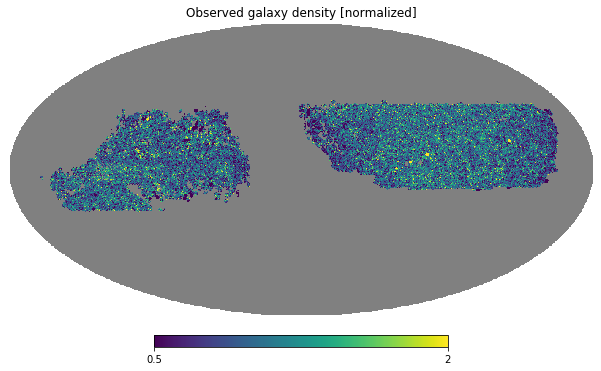

In [1]:
#
# importing general Python modules
#
import sys 
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import fitsio as ft

# 
# importing SYSNET modules
#
sys.path.append('/home/mehdi/github/sysnetdev')
from sysnet import SYSNet, Config, TrainedModel
%matplotlib inline

# tabulated catalog that contains, imaging properties (features), galaxy counts (label), 
# HEALPix index (hpix), and pixel completeness (fracgood)
input_ = ft.read('../input/eBOSS.ELG.NGC.DR7.table.fits')  # read tab. data
print(f'columns in `input`: {input_.dtype}')
     
# repackage hpix and label to a HEALPix map for visualization purpose    
nside = 256
ng = np.zeros(12*nside*nside)
ng[:] = np.nan
ng[input_['hpix']] = input_['label']    

# Mollweide projection
hp.mollview(ng, rot=-85, min=0.5, max=2.0,
            title='Observed galaxy density [normalized]')

SYSNet takes its input variables from a config file, `config.yaml`.

In [3]:
config = Config('../scripts/config.yaml')
config.__dict__

{'input_path': '../input/eBOSS.ELG.NGC.DR7.table.fits',
 'output_path': '../output/model_test',
 'restore_model': None,
 'batch_size': 512,
 'nepochs': 2,
 'nchains': 1,
 'find_lr': False,
 'find_structure': False,
 'find_l1': False,
 'do_kfold': False,
 'do_tar': False,
 'snapshot_ensemble': False,
 'normalization': 'z-score',
 'model': 'dnn',
 'optim': 'adamw',
 'scheduler': 'cosann',
 'axes': [0, 1, 2],
 'do_rfe': False,
 'eta_min': 1e-05,
 'learning_rate': 0.001,
 'nn_structure': [4, 20],
 'l1_alpha': -1.0,
 'loss': 'mse'}

In [4]:
# let's update some input arguments
config.update('nepochs', 300)
config.update('axes', [i for i in range(18)]) # num of features for this dataset
config.update('batch_size', 4096)

# run learning rate finder
config.update('find_lr', True)
pipeline = SYSNet(config) # perform regression
pipeline.run()

logging in ../output/model_test/train.log
# --- inputs params ---
input_path: ../input/eBOSS.ELG.NGC.DR7.table.fits
output_path: ../output/model_test
restore_model: None
batch_size: 4096
nepochs: 300
nchains: 1
find_lr: True
find_structure: False
find_l1: False
do_kfold: False
do_tar: False
snapshot_ensemble: False
normalization: z-score
model: dnn
optim: adamw
scheduler: cosann
axes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
do_rfe: False
eta_min: 1e-05
learning_rate: 0.001
nn_structure: [4, 20]
l1_alpha: -1.0
loss: mse
loss_kwargs: {'reduction': 'sum'}
optim_kwargs: {'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0, 'amsgrad': False}
scheduler_kwargs: {'eta_min': 1e-05, 'T_0': 10, 'T_mult': 2}
device: cpu
pipeline initialized in 0.050 s


# of data:,  187257


data loaded in 0.381 sec
# running pipeline ...
# training and evaluation
partition_0 with (4, 20, 18, 1)
# running hyper-parameter tunning ...
# running learning rate finder ... 


Learning rate search finished. See the graph with {finder_name}.plot()


SystemExit: LR finder done in 68.629 sec, check out ../output/model_test/loss_vs_lr_0.png

/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


![this image](../output/model_test/loss_vs_lr_0.png)

logging in ../output/model_test/train.log
# --- inputs params ---
input_path: ../input/eBOSS.ELG.NGC.DR7.table.fits
output_path: ../output/model_test
restore_model: None
batch_size: 4096
nepochs: 300
nchains: 1
find_lr: False
find_structure: False
find_l1: False
do_kfold: False
do_tar: False
snapshot_ensemble: False
normalization: z-score
model: dnn
optim: adamw
scheduler: cosann
axes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
do_rfe: False
eta_min: 1e-05
learning_rate: 0.05
nn_structure: [4, 20]
l1_alpha: -1.0
loss: mse
loss_kwargs: {'reduction': 'sum'}
optim_kwargs: {'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0, 'amsgrad': False}
scheduler_kwargs: {'eta_min': 1e-05, 'T_0': 10, 'T_mult': 2}
device: cpu
pipeline initialized in 0.030 s
data loaded in 0.203 sec
# running pipeline ...
# training and evaluation
partition_0 with (4, 20, 18, 1)


# of data:,  187257


base_train_loss: 0.139704
base_valid_loss: 0.142347
base_test_loss: 0.144221
# running training and evaluation with seed: 2664485226
Epoch 0/299 train loss: 0.320601 valid loss: 0.148593 lr: 0.048862
Epoch 1/299 train loss: 0.139031 valid loss: 0.138737 lr: 0.045390
Epoch 2/299 train loss: 0.135712 valid loss: 0.138373 lr: 0.039923
Epoch 3/299 train loss: 0.134988 valid loss: 0.137598 lr: 0.032995
Epoch 4/299 train loss: 0.134385 valid loss: 0.137145 lr: 0.025285
Epoch 5/299 train loss: 0.133940 valid loss: 0.136902 lr: 0.017548
Epoch 6/299 train loss: 0.133615 valid loss: 0.136476 lr: 0.010541
Epoch 7/299 train loss: 0.133391 valid loss: 0.136209 lr: 0.004950
Epoch 8/299 train loss: 0.133255 valid loss: 0.136141 lr: 0.001321
Epoch 9/299 train loss: 0.133180 valid loss: 0.136116 lr: 0.000012
Epoch 10/299 train loss: 0.133367 valid loss: 0.136725 lr: 0.049714
Epoch 11/299 train loss: 0.133065 valid loss: 0.135854 lr: 0.048820
Epoch 12/299 train loss: 0.132636 valid loss: 0.135484 lr: 0.

Epoch 119/299 train loss: 0.124881 valid loss: 0.129608 lr: 0.015472
Epoch 120/299 train loss: 0.124789 valid loss: 0.129556 lr: 0.014572
Epoch 121/299 train loss: 0.124712 valid loss: 0.129569 lr: 0.013689
Epoch 122/299 train loss: 0.124671 valid loss: 0.129576 lr: 0.012823
Epoch 123/299 train loss: 0.124628 valid loss: 0.129607 lr: 0.011975
Epoch 124/299 train loss: 0.124599 valid loss: 0.129586 lr: 0.011148
Epoch 125/299 train loss: 0.124549 valid loss: 0.129484 lr: 0.010342
Epoch 126/299 train loss: 0.124494 valid loss: 0.129404 lr: 0.009558
Epoch 127/299 train loss: 0.124447 valid loss: 0.129364 lr: 0.008799
Epoch 128/299 train loss: 0.124401 valid loss: 0.129327 lr: 0.008064
Epoch 129/299 train loss: 0.124349 valid loss: 0.129364 lr: 0.007356
Epoch 130/299 train loss: 0.124303 valid loss: 0.129439 lr: 0.006674
Epoch 131/299 train loss: 0.124282 valid loss: 0.129524 lr: 0.006021
Epoch 132/299 train loss: 0.124280 valid loss: 0.129631 lr: 0.005398
Epoch 133/299 train loss: 0.124276

Epoch 238/299 train loss: 0.122598 valid loss: 0.134858 lr: 0.020628
Epoch 239/299 train loss: 0.122514 valid loss: 0.128608 lr: 0.020146
Epoch 240/299 train loss: 0.122476 valid loss: 0.130848 lr: 0.019665
Epoch 241/299 train loss: 0.122409 valid loss: 0.130867 lr: 0.019187
Epoch 242/299 train loss: 0.122384 valid loss: 0.131915 lr: 0.018711
Epoch 243/299 train loss: 0.122356 valid loss: 0.131429 lr: 0.018237
Epoch 244/299 train loss: 0.122343 valid loss: 0.128497 lr: 0.017766
Epoch 245/299 train loss: 0.122281 valid loss: 0.128377 lr: 0.017298
Epoch 246/299 train loss: 0.122215 valid loss: 0.128364 lr: 0.016832
Epoch 247/299 train loss: 0.122228 valid loss: 0.128245 lr: 0.016370
Epoch 248/299 train loss: 0.122104 valid loss: 0.128349 lr: 0.015911
Epoch 249/299 train loss: 0.122094 valid loss: 0.128310 lr: 0.015456
Epoch 250/299 train loss: 0.122093 valid loss: 0.128453 lr: 0.015004
Epoch 251/299 train loss: 0.122101 valid loss: 0.128254 lr: 0.014557
Epoch 252/299 train loss: 0.122048

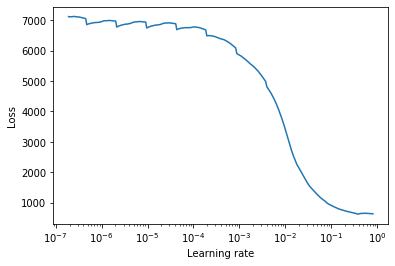

In [5]:
# let's re-train the network with the best learning rate
# monitor validation loss

config.update('find_lr', False) # remember to turn this off
config.update('learning_rate', 0.05)
pipeline = SYSNet(config) # perform regression
pipeline.run()

The code outputs several files:
1. `nn-weights.fits`: this file has healpix index and predicted galaxy count
2. `metrics.npz`: training, validation, test loss
3. `best.pth.tar`: the best model parameters

Load the trained model. You should know the name of the model and its architecture (i.e., the number of input features, hidden layers, and hidden layer units).

In [7]:
name_model = 'dnn'
path_model = '../output/model_test/model_0_2664485226/best.pth.tar'
kw_model = dict(nnstruct=(4, 20), num_features=18)

tm = TrainedModel(name_model, path_model, **kw_model)

In [8]:
hpix, npred = tm.forward('../input/eBOSS.ELG.NGC.DR7.table.fits') 
npred = npred / npred.mean()  # normalize
npred = npred.clip(0.5, 2.0)  # avoid extreme predictions


ng_ = np.zeros(12*256*256)
ng_[:] = np.nan
ng_[hpix] = npred

/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:1184: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:1185: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


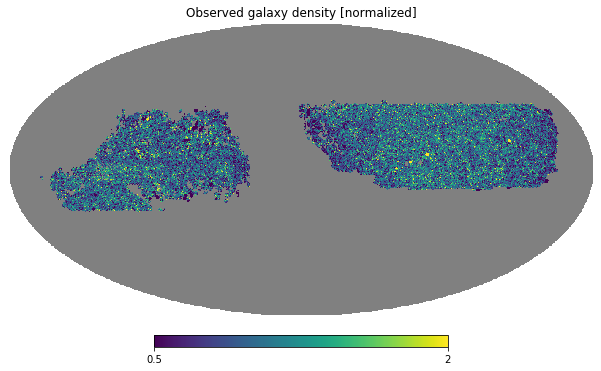

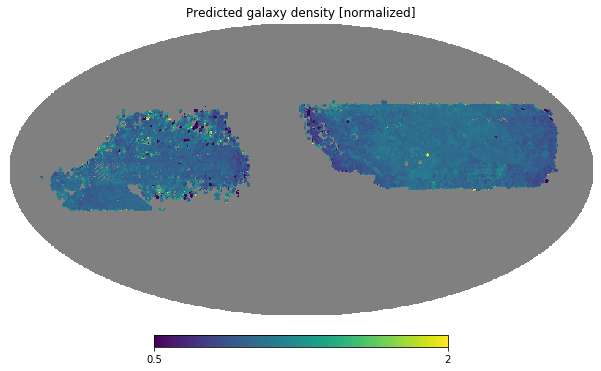

In [9]:
hp.mollview(ng, rot=-85, min=0.5, max=2.0,
            title='Observed galaxy density [normalized]')

hp.mollview(ng_, rot=-85, min=0.5, max=2.0,
            title='Predicted galaxy density [normalized]')

In [10]:
hp.write_map('../output/model_test/eBOSS.ELG.NGC.DR7.selection.fits', ng_, 
             dtype='float64', fits_IDL=False, overwrite=True)

For 300 training epochs, a single fold, and a single chain model, this is not a bad result. In practice, we use 5-fold validation (`do_kfold=True`) and train 20 chains (`nchains=20`) for 70-300 epochs.

If you have any questions, feel free to email me at mr095415@ohio.edu.